## Import Necessary Packages
#### Importing packages that exist natively in Jupyter Notebook environment

In [3]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import matplotlib.pyplot as plt
import seaborn as s 
from datetime import datetime,timedelta,date

In [416]:
from dateutil.relativedelta import relativedelta

In [144]:
from tabulate import tabulate

## Pip Install External Packages
#### Install packages from requirements document within IDE

In [8]:
pip install psycopg2


     ---------------------------------------- 1.2/1.2 MB 8.3 MB/s eta 0:00:00


## Import External Packages

In [10]:
import psycopg2 as psy

## Credentials Dictionary
#### Using personal credentials with password withheld, can use environmental variable for password

In [4]:
cred = {'host':'dataplor-api.csmbeii1hyqa.us-east-1.rds.amazonaws.com',
        'port':'5432',
        'db':'dataplor_production',
        'user':'simon',
        'password':'84ca7ec8eed67783e394ed1494d9de3979d52b6717e8bb1f899ccba80af556cc2ee99ed13d3b43b9b12e44bfc763bde2ddc684d843d7eb9490ec06d44e8354d5'}


## Credentials Function

In [5]:
def enter_credentials(host,user,password,port,database):
    url = f'postgresql://{user}:{password}@{host}:{port}/{database}'
    output = sql.create_engine(url)
    return output

## Instantiation of Credential Function

In [11]:
get_output = enter_credentials(cred['host'],
                               cred['user'],
                               cred['password'],
                               cred['port'],
                               cred['db'])

## Query Relevant Fields
#### Pulls in first 100,000 fields from places table as raw dataset

In [16]:
raw_POI = pd.read_sql_query(
"""with subset as (select * from places limit 100000)
select id,name,address,city,state,postal_code,neighborhood,country_code,chain_id,
case when chain_id is not null then 1 else 0 end as chain_bin,created_at,updated_at,coordinates,
business_category_id,external_ids ->> 'google_places_id' as google_places_id,
data ->> 'first_opened' as open_date,data ->> 'open_status' as open_status,
data ->> 'permanently_closed' as perm_closed,observation_dates ->> 'permanently_closed' as close_date
from subset""",get_output)

#### Declare date variable that is day 1 of 12 months ago

In [453]:
dt = datetime.combine(datetime(date.today().year,date.today().month,1),datetime.min.time())-relativedelta(years=1)

#### Dataframe of raw data from last 12 months

In [461]:
raw_poi_12 = raw_POI[raw_POI['created_at']>=dt]

#### Dataframe of raw data from first observation date to 12 full months ago

In [463]:
raw_poi_lt_12 = raw_POI[raw_POI['created_at']<dt]

#### Group Total POIs and Chain POIs by country

In [464]:
country_grouped = pd.DataFrame(raw_POI.groupby(['country_code'])['chain_bin'].agg(
   ['count','sum'])).rename(columns={'count':'Total POIs','sum':'Chain POIs'})

#### Distinct brands per country

In [465]:
distinct_brand = pd.DataFrame(raw_POI.groupby('country_code')['chain_id'].nunique()).rename(
    columns={'chain_id':'Distinct Chains'})

#### Add chain percentage to brand table

In [466]:
country_grouped['chain_pct'] = country_grouped['Chain POIs']/country_grouped['Total POIs']

#### Add distinct chain count to group by country

In [467]:
POI_and_Brand_Counts = country_grouped.merge(distinct_brand,on = 'country_code',how='left')

#### Format POI and Brand Count table 

In [468]:
POI_and_Brand_Counts['Chain Percentage'] = round(round(POI_and_Brand_Counts['chain_pct'],3)*100,2).astype(str)+'%'
POI_and_Brand_Counts_tab = POI_and_Brand_Counts.drop(columns=['chain_pct']).reset_index().rename(
    columns={'country_code':'Country'})

## Function for Previous Steps

In [469]:
def metrics_by_country(dt):
    country_grouped = pd.DataFrame(dt.groupby(['country_code'])['chain_bin'].agg(
    ['count','sum'])).rename(columns={'count':'Total POIs','sum':'Chain POIs'})
    distinct_brand = pd.DataFrame(dt.groupby('country_code')['chain_id'].nunique()).rename(
        columns={'chain_id':'Distinct Chains'})
    country_grouped['chain_pct'] = country_grouped['Chain POIs']/country_grouped['Total POIs']
    POI_and_Brand_Counts = country_grouped.merge(distinct_brand,on = 'country_code',how='left')
    POI_and_Brand_Counts['Chain Percentage'] = round(round(POI_and_Brand_Counts['chain_pct'],3)*100,2).astype(str)+'%'
    POI_and_Brand_Counts_tab = POI_and_Brand_Counts.drop(columns=['chain_pct']).reset_index().rename(
    columns={'country_code':'Country'})
    return POI_and_Brand_Counts_tab

## Run for raw data and last 12 months data

In [470]:
all_POIs = metrics_by_country(raw_POI)
last_12 = metrics_by_country(raw_poi_12)
before_12 = metrics_by_country(raw_poi_lt_12)

#### Function for top n countries

In [471]:
def top_countries(dt,n):
    return dt.nlargest(n,'Total POIs')

In [472]:
top_7 = top_countries(all_POIs,7)

#### Create "Rest Of World" category from omitted top n countries, calculate metrics, and format

In [473]:
rest_of_world = all[~all['Country'].isin(top_n['Country'].unique())]
rest_of_world = pd.DataFrame({'Country':['Rest of World'],'Total POIs':[np.sum(rest_of_world['Total POIs'])],'Chain POIs':
                                                                        [np.sum(rest_of_world['Chain POIs'])],
                                                                        'Distinct Chains':[np.sum(
                                                                            rest_of_world['Distinct Chains'])]})
rest_of_world['Chain Percentage'] = round(round(rest_of_world['Chain POIs']/
                                                rest_of_world['Total POIs'],3)*100,2).astype(str)+'%'


#### Add rest of world category to top n group by country

In [474]:
top_pois = pd.concat([top_7,rest_of_world])

#### Map countries to country code

In [475]:
top_pois_2 = top_pois.set_index('Country').rename(index={'in':'India','cn':'China','id':'Indoneisa','pl':'Poland','br':'Brazil','mx':'Mexico',
                                     'us':'United States'})

#### Add month/year of POI collection and country code or rest of world indicator field 

In [476]:
raw_poi_12['created_at_month'] = raw_poi_12['created_at'].dt.to_period('M')
raw_poi_12['Country Code'] = np.where(raw_poi_12['country_code'].isin(top_n['Country']),
                                      raw_poi_12['country_code'],'Rest of World')

C:\Users\simle\AppData\Local\Temp\ipykernel_24444\4226369495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_poi_12['created_at_month'] = raw_poi_12['created_at'].dt.to_period('M')
C:\Users\simle\AppData\Local\Temp\ipykernel_24444\4226369495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_poi_12['Country Code'] = np.where(raw_poi_12['country_code'].isin(top_n['Country']),


#### Sum of new openings by month group by country

In [478]:
POI_by_month = pd.DataFrame(pd.pivot_table(raw_poi_12,values = 'created_at', index=['created_at_month'], 
                                           columns = ['Country Code'],aggfunc= 'count').replace(np.nan,0)).reset_index()
poi_2 = POI_by_month.set_index('created_at_month').cumsum(axis=0).reset_index()

#### Group number of chain POIs collected by month/year

In [480]:
chain_count_by_month = pd.DataFrame(raw_poi_12.groupby('created_at_month').chain_bin.sum().cumsum().reset_index()).rename(
    columns={'chain_bin':'Chain Count'})

#### Group chain count by month/year and country and format

In [483]:
chain_POI_by_month = pd.DataFrame(pd.pivot_table(raw_poi_12[raw_poi_12['chain_bin']==1],
                                                 values = 'created_at', index=['created_at_month'], 
                                           columns = ['Country Code'],aggfunc= 'count').replace(np.nan,0)).reset_index()
cp2 = chain_POI_by_month.set_index('created_at_month')
cp3 = cp2.cumsum(axis=0)
cp4 = cp3.reset_index()

#### Remove duplicate chain ids in order of descending occurence

In [503]:
distinct_chain = raw_POI[raw_POI['chain_id'].notnull()][['created_at','chain_id']]
distinct_chain['created_at_month'] = distinct_chain['created_at'].dt.to_period('M')
distinct_chain_filtered = distinct_chain.sort_values('created_at_month').drop_duplicates('chain_id',keep='last')
distinct_chain_df = pd.DataFrame(pd.pivot_table(distinct_chain_filtered,values = 'created_at', index=['created_at_month'], 
                                           aggfunc= 'count').replace(np.nan,0)).reset_index()

#### Create month/year variable for comparison from dt

In [540]:
#print(type(dc3.iloc[1,0]))
dt_month = pd.Timestamp(dt).to_period('M')

#### Formatting

In [541]:
dc2 = distinct_chain_df.set_index('created_at_month').cumsum(axis=0).reset_index()
#dc3 = dc2.cumsum(axis=0).reset_index()
dc3 = dc2[dc2['created_at_month']>=dt_month].rename(columns = {'created_at':'Chain POIs'})

#### Create freshness metric fields by assigning time since last update for each POI

In [542]:
raw_poi_12['Less than 30 Days'] = np.where(raw_poi_12['updated_at'] > pd.to_datetime(date.today())-timedelta(days=30),1,0)
raw_poi_12['Less than 60 Days'] = np.where((raw_poi_12['updated_at'] > pd.to_datetime(date.today())-timedelta(days=60)),1,0)
raw_poi_12['Less than 90 Days'] = np.where((raw_poi_12['updated_at'] > pd.to_datetime(date.today())-timedelta(days=90)),1,0)
freshness_df = pd.pivot_table(raw_poi_12,values=['id','chain_bin','Less than 30 Days','Less than 60 Days','Less than 90 Days'],
                              index = ['Country Code'],aggfunc={'id':'count','chain_bin':np.sum,'Less than 30 Days':np.sum,
                                                                'Less than 60 Days':np.sum,'Less than 90 Days':np.sum})
freshness_df['Less than 30 Days'] = round(round(freshness_df['Less than 30 Days']/freshness_df['id'],3)
                                          *100,2).astype(str)+'%'
freshness_df['Less than 60 Days'] = round(round(freshness_df['Less than 60 Days']/freshness_df['id'],3)
                                          *100,2).astype(str)+'%'
freshness_df['Less than 90 Days'] = round(round(freshness_df['Less than 90 Days']/freshness_df['id'],3)
                                          *100,2).astype(str)+'%'
freshness_df = pd.DataFrame(freshness_df).rename(columns={'chain_bin':'Brand Count','id':'POI Count'})

C:\Users\simle\AppData\Local\Temp\ipykernel_24444\649112428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_poi_12['Less than 30 Days'] = np.where(raw_poi_12['updated_at'] > pd.to_datetime(date.today())-timedelta(days=30),1,0)
C:\Users\simle\AppData\Local\Temp\ipykernel_24444\649112428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_poi_12['Less than 60 Days'] = np.where((raw_poi_12['updated_at'] > pd.to_datetime(date.today())-timedelta(days=60)),1,0)
C:\Users\simle\AppData\Local\Temp\ipyker

#### Group new POIs per month by country dataframe

In [543]:
POI_by_month = pd.DataFrame(pd.pivot_table(raw_poi_12,values = 'created_at', index=['created_at_month'], 
                                           columns = ['Country Code'],aggfunc= 'count').replace(np.nan,0)).reset_index()

#### Convert to cumulative POI count

In [544]:
POI_open_closing = pd.DataFrame(pd.pivot_table(raw_poi_12,values = ['open_date','close_date'],index=['created_at_month'],
                                               aggfunc='count')).reset_index()
poc2 = POI_open_closing.set_index('created_at_month').cumsum(axis=0).rename(
    columns = {'open_date':'Open Date','close_date':'Close Date'}).reset_index()
 

#### Group and sort POI count by business category

In [545]:
POI_Business_Category = pd.DataFrame(pd.pivot_table(raw_POI,values='id',index='business_category_id',aggfunc='count')
                                    ).rename(columns={'business_category_id':'Business Category','id':'POI Count'}
                                            ).reset_index().sort_values(by=['POI Count'],ascending=False) 


#### Format freshness dataframe

In [547]:
freshness_df_2 = pd.pivot_table(raw_poi_12,values=['id','chain_bin','Less than 30 Days','Less than 60 Days','Less than 90 Days'],
                              index = ['Country Code'],aggfunc={'id':'count','chain_bin':np.sum,'Less than 30 Days':np.sum,
                                                                'Less than 60 Days':np.sum,'Less than 90 Days':np.sum})


In [549]:
freshness_df_2['lt30'] = round(round(freshness_df_2['Less than 30 Days']/freshness_df_2['id'],3)
                                          *100,2)

#### Add breakdown of 100% for freshness barchart

In [550]:
fdf3 = freshness_df_2[['lt30']]
fdf3['pct'] = 100 - fdf3['lt30']
fdf4 = fdf3.rename(columns = {'lt30':'0-30 Days','pct':'31-60 Days'}).reset_index()
fdf5 = fdf4[fdf4['Country Code'] != 'Rest of World']

C:\Users\simle\AppData\Local\Temp\ipykernel_24444\3346831772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf3['pct'] = 100 - fdf3['lt30']


In [553]:
POI_Business_Category.rename(columns = {'business_category_id':'Business Category'})

,Business Category,POI Count
2744,store,4801
2421,restaurant,2370
1389,hindu_temple,1720
605,clothing_store,1690
2496,school,1623
...,...,...
984,emergency_services,1
982,emergency_locksmith_service,1
2439,road_cycling,1
973,elevator_manufacturer,1


# Summary Statistics Output

## Counts from Latest Release

In [305]:
print(tabulate(top_pois_2.sort_values(by=['Total POIs'],ascending = False),headers='keys',tablefmt='fancy_grid'))

╒═══════════════╤══════════════╤══════════════╤═══════════════════╤════════════════════╕
│ Country       │   Total POIs │   Chain POIs │   Distinct Chains │ Chain Percentage   │
╞═══════════════╪══════════════╪══════════════╪═══════════════════╪════════════════════╡
│ Rest of World │        37400 │          256 │               157 │ 0.7%               │
├───────────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ India         │        34247 │           22 │                19 │ 0.1%               │
├───────────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ China         │         8962 │            1 │                 1 │ 0.0%               │
├───────────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ Indoneisa     │         7178 │            3 │                 3 │ 0.0%               │
├───────────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ Poland        │    

## POI and Brand Counts - Top 30 Countries

In [309]:
print(tabulate(POI_and_Brand_Counts_tab.sort_values(by=['Total POIs'],ascending = False).iloc[:30,:],
               headers='keys',tablefmt='fancy_grid',showindex=False))

╒═══════════╤══════════════╤══════════════╤═══════════════════╤════════════════════╕
│ Country   │   Total POIs │   Chain POIs │   Distinct Chains │ Chain Percentage   │
╞═══════════╪══════════════╪══════════════╪═══════════════════╪════════════════════╡
│ in        │        34247 │           22 │                19 │ 0.1%               │
├───────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ cn        │         8962 │            1 │                 1 │ 0.0%               │
├───────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ id        │         7178 │            3 │                 3 │ 0.0%               │
├───────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ pl        │         5297 │           17 │                 7 │ 0.3%               │
├───────────┼──────────────┼──────────────┼───────────────────┼────────────────────┤
│ br        │         4034 │           22 │                14 │ 0

## Counts from Last 12 Months

<AxesSubplot:title={'center':'POI Count by Month'}, xlabel='Month', ylabel='Cumulative Opened POIs'>

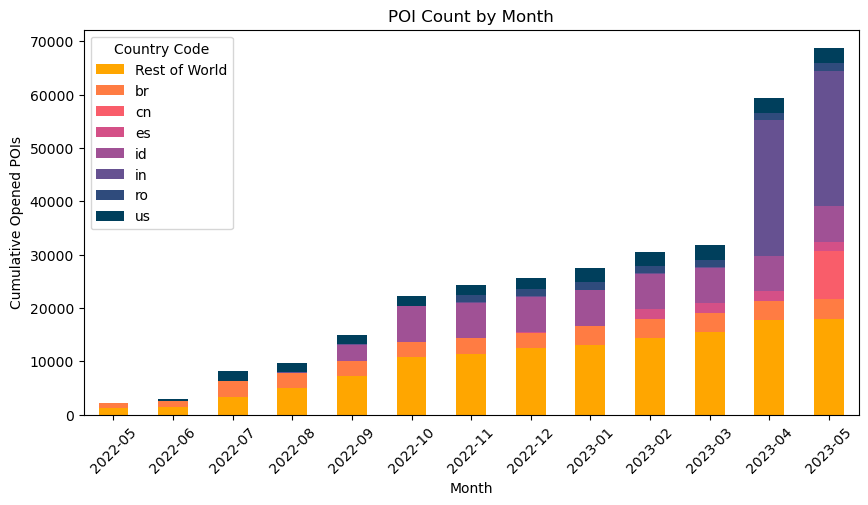

In [374]:
poi_2.plot(x='created_at_month',kind='bar',stacked=True,title = 'POI Count by Month',
                  color = ['#ffa600','#ff7c43','#f95d6a','#d45087','#a05195','#665191','#2f4b7c','#003f5c'],
           figsize = (10,5),xlabel = 'Month',ylabel = 'Cumulative Opened POIs',rot=45)

## Chain Counts from Last 12 Months

<AxesSubplot:title={'center':'Chain POIs by Month'}, xlabel='Month', ylabel='Cumulative Opened Chains'>

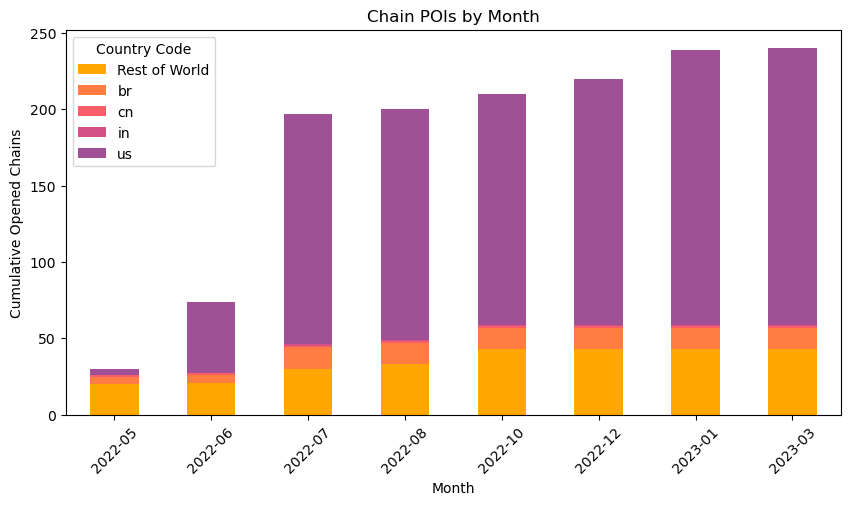

In [375]:
cp4.plot(x='created_at_month',kind='bar',stacked=True,title = 'Chain POIs by Month',
                  color = ['#ffa600','#ff7c43','#f95d6a','#d45087','#a05195'],
           figsize = (10,5),xlabel = 'Month',ylabel = 'Cumulative Opened Chains',rot = 45)

## Distinct Brand Count Overall - Last 12 Months

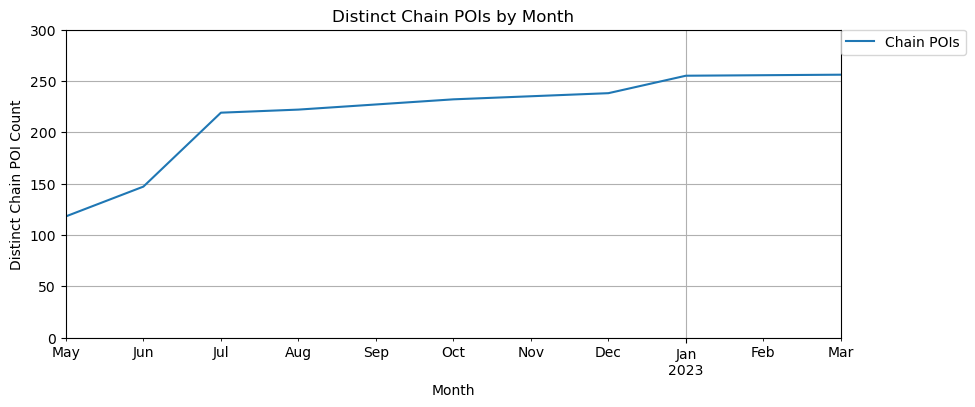

In [391]:
dc4.plot(x='created_at_month',kind='line',title = 'Distinct Chain POIs by Month',figsize = (10,4),
         xlabel = 'Month',ylabel = 'Distinct Chain POI Count',ylim = (0,300),grid = True)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

## Brand Freshness

╒════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════════╤═════════════╕
│ Country Code   │ Less than 30 Days   │ Less than 60 Days   │ Less than 90 Days   │   Brand Count │   POI Count │
╞════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════════╪═════════════╡
│ Rest of World  │ 78.5%               │ 100.0%              │ 100.0%              │            43 │       18003 │
├────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────────┼─────────────┤
│ br             │ 66.0%               │ 100.0%              │ 100.0%              │            14 │        3628 │
├────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────────┼─────────────┤
│ cn             │ 100.0%              │ 100.0%              │ 100.0%              │             1 │        8962 │
├────────────────┼─────────────────────┼─────────────────────┼──────────────────

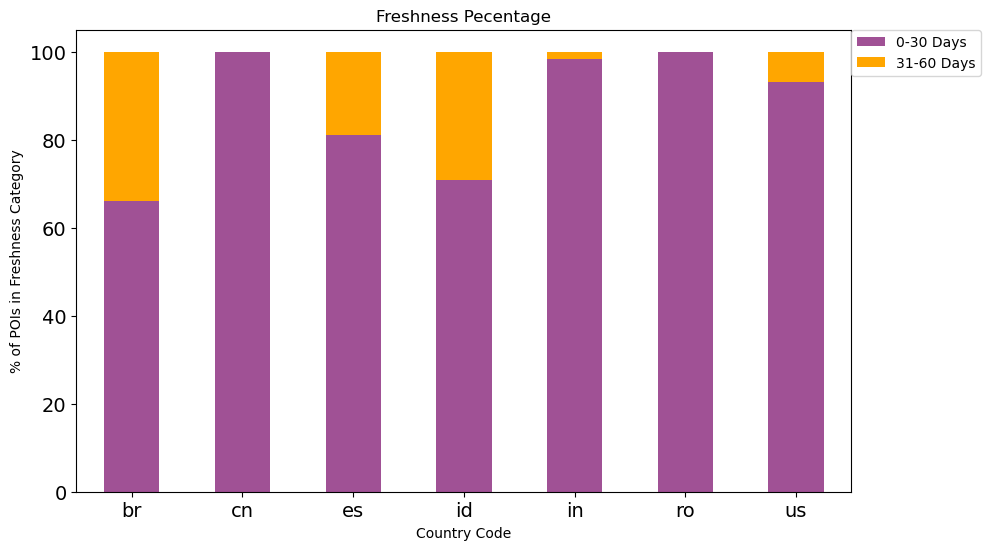

In [383]:
print(tabulate(freshness_df,headers='keys',tablefmt='fancy_grid'))
fdf5.plot(x = 'Country Code',kind='bar',stacked=True,ylabel = '% of POIs in Freshness Category',
          title = 'Freshness Pecentage',color=['#a05195','#ffa600'],figsize = (10,6),fontsize = 14,rot=0)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

## POI Open and Closing Rates

<AxesSubplot:title={'center':'POI Openings/Closing by Month'}, xlabel='Month', ylabel='Cumulative POIs'>

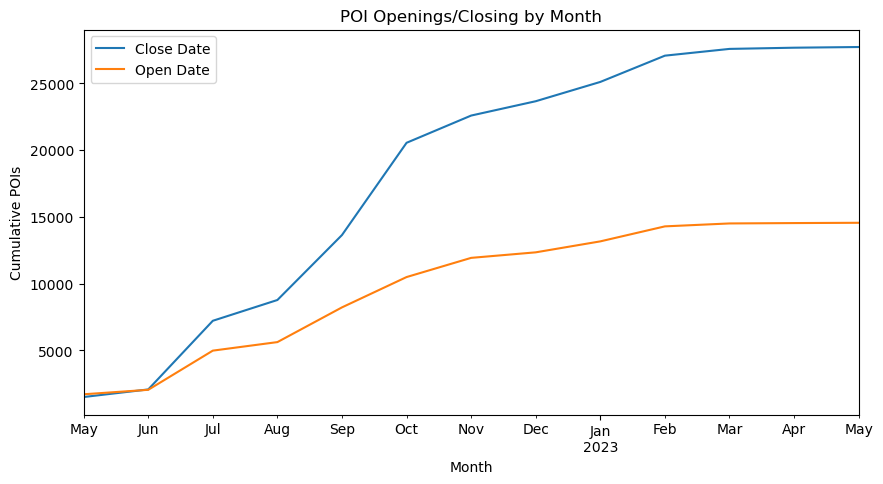

In [389]:
poc2.plot(x='created_at_month',kind='line',title = 'POI Openings/Closing by Month',figsize = (10,5),xlabel = 'Month',
          ylabel = 'Cumulative POIs')

## Category Statistics

In [378]:
BC2 = POI_Business_Category.rename(columns = {'business_category_id':'Business Category'})
print(tabulate(BC2.iloc[:10,:],headers = 'keys',tablefmt = 'fancy_grid',showindex = False))
#print(tabulate(freshness_df,headers='keys',tablefmt='fancy_grid'))

╒═════════════════════╤═════════════╕
│ Business Category   │   POI Count │
╞═════════════════════╪═════════════╡
│ store               │        4801 │
├─────────────────────┼─────────────┤
│ restaurant          │        2370 │
├─────────────────────┼─────────────┤
│ hindu_temple        │        1720 │
├─────────────────────┼─────────────┤
│ clothing_store      │        1690 │
├─────────────────────┼─────────────┤
│ school              │        1623 │
├─────────────────────┼─────────────┤
│ grocery_store       │        1396 │
├─────────────────────┼─────────────┤
│ corporate_office    │        1390 │
├─────────────────────┼─────────────┤
│ apartment_building  │        1210 │
├─────────────────────┼─────────────┤
│ hotel               │        1032 │
├─────────────────────┼─────────────┤
│ business_center     │        1030 │
╘═════════════════════╧═════════════╛
